# APM466 Assignment 1: Yield Curves

## Question 4

In [199]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
import scipy
from scipy import optimize
from scipy.interpolate import interp1d

In [200]:
selected_ISINs = ['CA135087K296', 'CA135087K601', 'CA135087L286', 'CA135087L773',
                  'CA135087A610', 'CA135087J546', 'CA135087J967', 'CA135087K528',
                  'CA135087K940', 'CA135087L518']
dates = ['2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22',
        '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29']

data = pd.read_csv("apm466_a1.csv", index_col=0, parse_dates=['maturity_date', 
                                                              'issue_date'])
selected = data.loc[selected_ISINs].sort_values(by=['maturity_date'])

daycount = [0, 0, 0, 0, 120, 28, 28, 28, 28, 28] # number of days until the next coupon payment
num_coupon = [2, 3, 4, 5, 5, 7, 8, 9, 10, 11] # number of remaining coupon payments
ttm = [6/12, 12/12, 18/12, 24/12, 28/12, 37/12, 43/12, 49/12, 55/12, 61/12] # time to maturity

In [216]:
def dcf(amt, ytm, freq, period):
    pv = amt / (1 + ytm/freq) ** period
    return pv

def get_bond_price(daycount, num_coupon, n, cr, freq, ytm):
    dirty_price = 0
    
    # calculate the present values of all future coupon payments
    c = n * cr/100 / freq
    w = daycount/183

    for i in range(num_coupon):
        dirty_price += dcf(c, ytm, freq, w)
        w += 1

    # calculate the present value of the notional
    dirty_price += dcf(n, ytm, freq, w-1)

    # calculate the accured interest of the bond
    accured_interest = (183-daycount)/365 * cr/100 * n    # assume actual/365 convention
    
    # calculate the clean price of the bond
    clean_price = dirty_price - accured_interest

    return clean_price

def get_yield(daycount, num_coupon, n, cr, freq, price, estimate=0.05):
    get_yield = lambda ytm: get_bond_price(daycount, num_coupon, n, cr, freq, ytm) - price

    return optimize.newton(get_yield, estimate)

### Part (a)

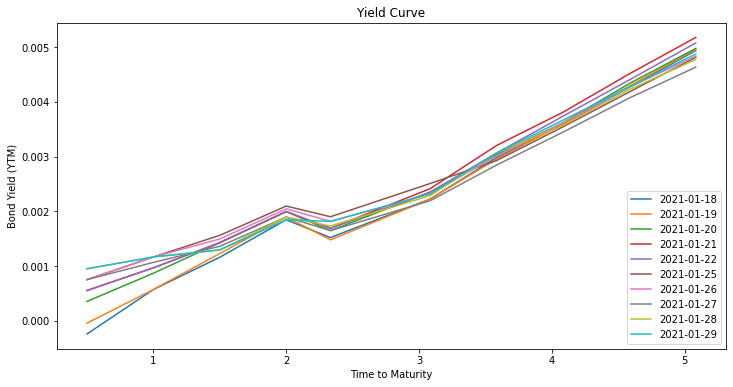

In [203]:
###### calculate bond yields ######
freq = 2    # assume semi-annual compounding
n = 100     # assume the notional is 100 CAD
ytm = {}

for date in dates:
    ytm[date] = []
    i = 0

    for ISIN in selected_ISINs:
        # extract information for yield calculation
        bond = selected.loc[ISIN]
        cr = bond.loc['coupon']
        price = bond.loc[date]
        count = daycount[i]
        num = num_coupon[i]
        
        # calculate the yield
        bond_yield = get_yield(count, num, n, cr, freq, price)
        ytm[date].append(bond_yield)

        i += 1

###### plot the yield curves ######
plt.figure(figsize=(12, 6))
for date in ytm:
    plt.plot(ttm, ytm[date], label=date)

plt.title("Yield Curve")
plt.xlabel("Time to Maturity")
plt.ylabel("Bond Yield (YTM)")
plt.legend(loc='lower right')
plt.show()

### Part (b)

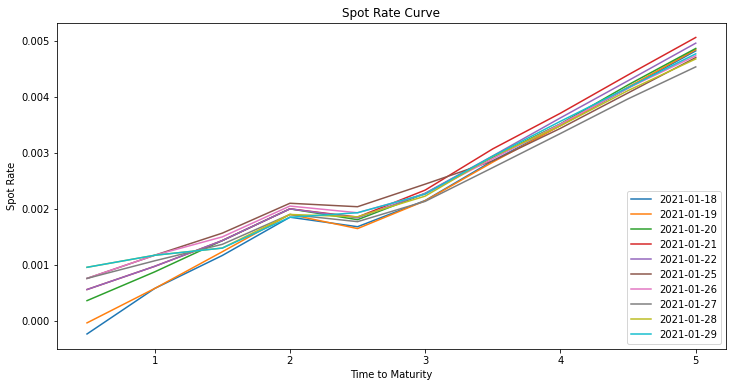

In [217]:
###### get interpolated rates on the yield curve ######
time = list(np.linspace(0.5, 5, 10))
par_yield = {}

for date in dates:
    par_yield[date] = []
    interp = interp1d(ttm, ytm[date], bounds_error=False, fill_value=scipy.nan)
    for t in time:
        val = float(interp(t))
        if not np.isnan(val):
            par_yield[date].append(val)

###### calculate the spot rates ######
spot = {}

for date in dates:
    spot[date] = []
    for i in range(0, len(time)):
        sum = 0
        # on the par yield curve, par yield rate = coupon rate
        n = 1 # assume the notional is 1
        c = par_yield[date][i]/2 * 1
        
        for j in range(0, i):
            sum += c / (1+spot[date][j]) ** (time[j]*2)
        
        value = ((n+c) / (1-sum)) ** (1/(time[i]*2)) - 1
        spot[date].append(value*2)

###### plot the spot rate curves ######
plt.figure(figsize=(12, 6))
for date in spot:
    plt.plot(time, spot[date], label=date)

plt.title("Spot Rate Curve")
plt.xlabel("Time")
plt.ylabel("Spot Rate")
plt.legend(loc='lower right')
plt.show()

### Part (c)

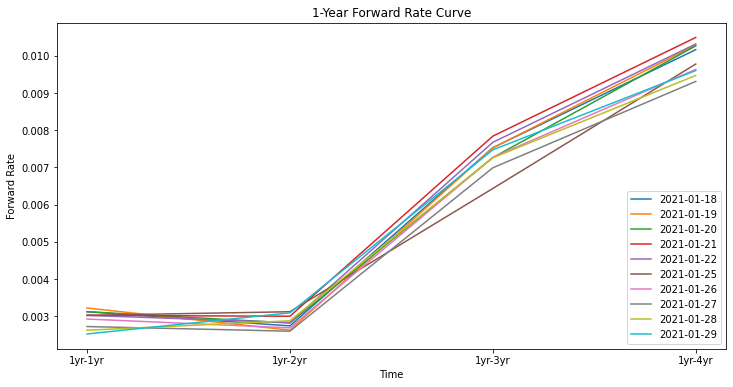

In [226]:
###### calculate the forward rates ######
label = ["1yr-1yr", "1yr-2yr", "1yr-3yr", "1yr-4yr"]
forward = {}

for date in dates:
    forward[date] = []
    for i in range(0, 4):
        prod = (1 + spot[date][1])
        for j in range(0, i):
            prod *= (1 + forward[date][j])
        
        value = (1+spot[date][2*i+3])**(i+2) / prod - 1
        forward[date].append(value)

###### plot the forward rate curves ######
plt.figure(figsize=(12, 6))
for date in forward:
    plt.plot(label, forward[date], label=date)

plt.title("1-Year Forward Rate Curve")
plt.xlabel("Time")
plt.ylabel("Forward Rate")
plt.legend(loc='lower right')
plt.show()

## Question 5

In [247]:
###### calculate the covariance matrices ######
# covariance matrices for daily log-returns of yields
ret_list = [[],[],[],[],[]]

for i in range(5):
    for j in range(len(dates)-1):
        ret = math.log(par_yield[dates[j+1]][2*i+1]/par_yield[dates[j]][2*i+1])
        ret_list[i].append(ret)

x = np.array(ret_list)
cov1 = np.cov(x)

# covariacne matrices for forward rates
forward_array = [[],[],[],[]]

for i in range(4):
    for j in range(len(dates)-1):
        val = math.log(forward[dates[j+1]][i]/forward[dates[j]][i])
        forward_array[i].append(val)

y = np.array(forward_array)
cov2 = np.cov(y)

###### print out the results ######
print("covariance matrix of log returns:\n", cov1)
print("\ncovariance matrix of forward rates:\n", cov2)

covariance matrix of log returns:
 [[2.24974580e-02 4.66835389e-03 5.66841585e-03 7.80148271e-04
  4.95272437e-04]
 [4.66835389e-03 1.60924257e-03 1.53730225e-03 6.59916680e-05
  5.10053167e-05]
 [5.66841585e-03 1.53730225e-03 2.57968626e-03 2.73301583e-04
  2.44054619e-04]
 [7.80148271e-04 6.59916680e-05 2.73301583e-04 1.38237206e-03
  1.16436692e-03]
 [4.95272437e-04 5.10053167e-05 2.44054619e-04 1.16436692e-03
  1.00403250e-03]]

covariance matrix of forward rates:
 [[ 8.87931924e-04 -2.24298619e-04 -6.86293641e-04  1.56645587e-05]
 [-2.24298619e-04  7.59210784e-03 -3.05123763e-03  4.18287302e-04]
 [-6.86293641e-04 -3.05123763e-03  7.17728053e-03  1.50957039e-03]
 [ 1.56645587e-05  4.18287302e-04  1.50957039e-03  6.61275046e-04]]


## Question 6

In [245]:
###### calculate eigenvalues and eigenvectors of covariance matrices ######
eigval1,eigvec1 = np.linalg.eig(cov1)
eigval2,eigvec2 = np.linalg.eig(cov2)

###### print out the results ######
print("eigenvalue of log return covariance:\n", eigval1)
print("\neigenvector of log return covariance:\n", eigvec1)
print("\neigenvalue of forward rate covariance:\n", eigval2)
print("\neigenvector of forward rate covariance:\n", eigvec2)

eigenvalue of log return covariance:
 [2.50682400e-02 2.34688850e-03 1.20812357e-03 4.38374402e-04
 1.11649332e-05]

eigenvector of log return covariance:
 [[-0.94463136 -0.05036931 -0.31512782  0.07436994  0.01726566]
 [-0.20470125 -0.06175114  0.41362519 -0.88477599 -0.01923149]
 [-0.25279221  0.06944437  0.85183183  0.45251147 -0.02982411]
 [-0.035789    0.75539504 -0.06311385 -0.05985086 -0.64848439]
 [-0.02417106  0.64668814 -0.00279885 -0.05737432  0.76020429]]

eigenvalue of forward rate covariance:
 [1.05084574e-02 4.87524869e-03 6.92154111e-05 8.65673788e-04]

eigenvector of forward rate covariance:
 [[ 0.03282728  0.14960527 -0.31269145 -0.9374245 ]
 [ 0.71395787 -0.67676146 -0.17804623 -0.0236139 ]
 [-0.6952551  -0.65488793 -0.29462992 -0.03058354]
 [-0.07620279 -0.30122083  0.88527781 -0.34603806]]
